# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
  1.0
 -1.0
  1.0
  1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
  1.0
  ⋮
  1.0
  1.0
  1.0
  1.0
 -1.0
  1.0
 -1.0
 -1.0
  1.0

### We create a function to visualize the data

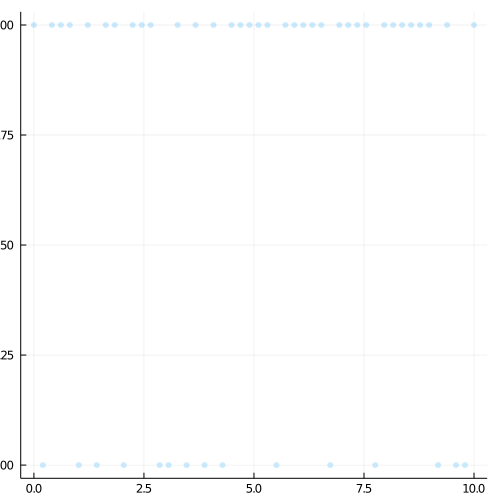

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.071166 seconds (2.09 M allocations: 120.555 MiB, 99.59% compilation time)


(Variational Gaussian Process with a Bernoulli Likelihood with Logistic Link infered by Analytic Variational Inference , (local_vars = (c = [0.8551605655548714, 0.8388347743155846, 0.8275024592767759, 0.820134583412103, 0.815206576603479, 0.8108338602778423, 0.805388344535576, 0.7967419374778569, 0.7832458327100155, 0.7630722395868248  …  1.2304419794815387, 1.1757194431713502, 1.093192520033628, 0.9888728658593221, 0.8757485384459769, 0.7726014567005378, 0.7001249085329637, 0.6715460075225786, 0.6850270426283656, 0.7260279628348315], θ = [0.23580199470695173, 0.236303686181035, 0.2366477307045285, 0.23686954752706085, 0.23701708084825238, 0.2371474303454912, 0.23730902007206048, 0.23756389621821516, 0.2379575293583338, 0.2385362340006616  …  0.2225996237297671, 0.2246941454362065, 0.22775715397163124, 0.23144050431210697, 0.23515933027100472, 0.23826433487645632, 0.24026493467939528, 0.24100992017778816, 0.24066167588485063, 0.23956795163831918]), opt_state = (NamedTuple(),), hyperopt

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:06:04
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:05
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:03
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:32
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:13
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:01
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:52
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:45
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:40
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.00044832765903490834, -0.11654454758877697, -0.17562285061850824, -0.17679449279474024, -0.04901307054358217, 0.10473297313769725, 0.3363013571836039, 0.5176705615183463, 0.7005219101267575, 0.7793985006784929  …  1.2717388400525194, 1.2502949078625378, 1.186860505617655, 1.0678780306074738, 0.8241813452186268, 0.5164762641016087, 0.12889176998401852, -0.26674782967619637, -0.6036636407920792, -0.8460672826314501]]
 [[0.34862193560521154, 0.15113537950079303, -0.08030502181523702, -0.2230896397174728, -0.34261141273888784, -0.4217130099153692, -0.4902129756393121, -0.555528711603656, -0.6402684641426398, -0.780955369287236  …  1.2652361763574427, 1.2107125936182925, 1.1336030544962519, 1.0153278273979036, 0.8926360247705929, 0.7096687497163838, 0.5649488443341538, 0.414165015011984, 0.295347610546431, 0.24350452534721162]]
 [[0.6859674803685682, 0.8156447233314508, 0.9424385343177463, 1.053767729163392, 1.1595625915258734, 1.2477493716

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

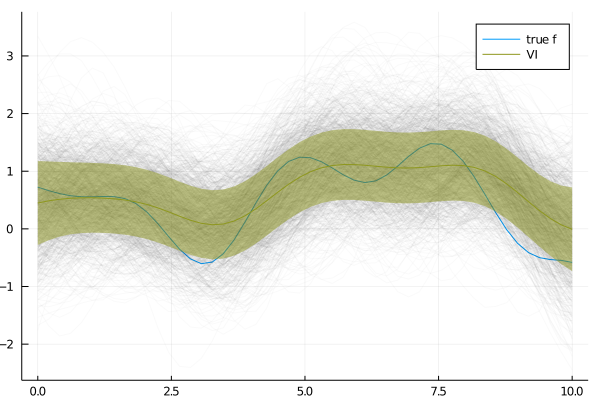

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

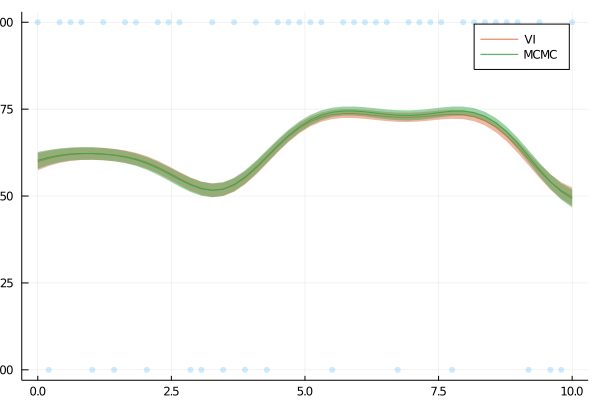

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*